# Spectral analysis of an EEG trace recorded from the human brain (from Backyard Brains)
`BackyardBrainsEEG.ipynb`

Notebook was created by _Etienne Ackermann_.

## Overview

[Backyard Brains](https://backyardbrains.com) has a very nice [experiment](https://backyardbrains.com/experiments/eeg) where they introduce the _"much sought after, often misunderstood, signal of neuroscience: the Electroencephalogram (EEG)"._ In this notebook, we will take the recorded EEG trace from Backyard Brains, and analyze the spectral content in a few different ways, including with the very cool generalized **Morse wavelet** transform.

### Preliminaries

The following Python packages will be used in this tutorial:

**For downloading example data from the web:**
```python
1. requests   # used to download data from web
2. tqdm       # used to show progress of download
```

**the rest of this notebook:**
```python
3. numpy      # numerical powerhorse for Python (for matrix and vector calculations)
4. matplotlib # used to make plots and figures
5. scipy      # signal processing, stats, etc.
6. sklearn    # machine learning in Python
```

**and of course:**
```python
7. nelpy      # electrophysiology data containers
8. ghost      # spectral analysis routines
```

### Installation

Packages 1-7 above can be installed either with `conda install <pkg>` or with `pip install <pkg>`. Many of these are very common, and it is more than likely that you have at least one of them installed already. 

It doesn't hurt to type `pip install <pkg>` if the package is already installed, so don't be nervous to try it out! Example:
```bash
pip install nelpy
```


For ```ghost``` please type:

```bash
pip install git+https://github.com/nelpy/ghost.git
```

Now that we have all the packages we need, let's get started! First, we need to get the sample data...

## 1. Obtain example data

In [1]:
import os

import requests
from tqdm import tqdm

datadir = os.path.join(os.getcwd(), "example-data/eeg")
os.makedirs(datadir, exist_ok=True)

filename = os.path.join(datadir, "EEG_Alpha_SampleData.zip")
url = "https://backyardbrains.com/experiments/files/EEG_Alpha_SampleData.zip"


if os.path.exists(filename):
    print("you already have the example data, skipping download...")
else:
    print("downloading data from {}".format(url))
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get("content-length", 0))
    chunk_size = 1024  # number of bytes to process at a time (NOTE: progress bar unit only accurate if this is 1 kB)

    with open(filename, "wb+") as f:
        for data in tqdm(
            r.iter_content(chunk_size), total=int(total_size / chunk_size), unit="kB"
        ):
            f.write(data)

    print("data saved to local directory {}".format(filename))

downloading data from https://backyardbrains.com/experiments/files/EEG_Alpha_SampleData.zip


363kB [00:00, 22721.99kB/s]            

data saved to local directory d:\github\nelpy\tutorials\example-data/eeg\EEG_Alpha_SampleData.zip


In [2]:
import zipfile

with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(path=datadir)

There are two pieces of data that we will load:

**`TimBrain_VisualCortex_BYB_Recording-events.txt`:** This is a file denoting the start and stop times for when Tim's eyes were closed. All times are in seconds.

**`TimBrain_VisualCortex_BYB_Recording.wav`:** The raw EEG recording, sampled at 10 kHz.

In [3]:
from scipy.io.wavfile import read as read_wavefile

rate, data = read_wavefile(
    datadir + "/EEG_Alpha_SampleData/TimBrain_VisualCortex_BYB_Recording.wav"
)

print("Data was recorded at a sampling rate of {} Hz".format(rate))

Data was recorded at a sampling rate of 10000 Hz


In [4]:
import numpy as np

bounds = []
ct = 0
with open(
    datadir + "/EEG_Alpha_SampleData/TimBrain_VisualCortex_BYB_Recording-events.txt",
    "r",
) as file:
    for line in file:
        y = line.split(",")
        if y[0] in ("eyes closed", "eyes open"):
            bounds.append(float(y[1].strip("\t").strip("\n")))
            ct += 1

if ct & 1:
    raise ValueError("File has {} boundaries but expected an even number".format(ct))

closed_intervals = np.array(bounds).reshape((ct // 2, 2))
print(closed_intervals)

[[ 4.2552 14.9426]
 [23.2801 36.0951]
 [45.4738 59.3751]
 [72.0337 85.0831]]


In [5]:
import nelpy as nel
import nelpy.plotting as npl

eeg = nel.AnalogSignalArray(data=data, fs=rate)
closed_epochs = nel.EpochArray(closed_intervals)

print("The 'eeg' object is now an {}".format(eeg))
print(
    "During the experiment, eyes were closed for {} out of {}.".format(
        closed_epochs.duration, eeg.support.duration
    )
)

The 'eeg' object is now an <AnalogSignalArray at 0x2a8cf3d7d90: 1 signals> for a total of 1:37:075 minutes
During the experiment, eyes were closed for 50.4531 seconds out of 1:37:075 minutes.


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

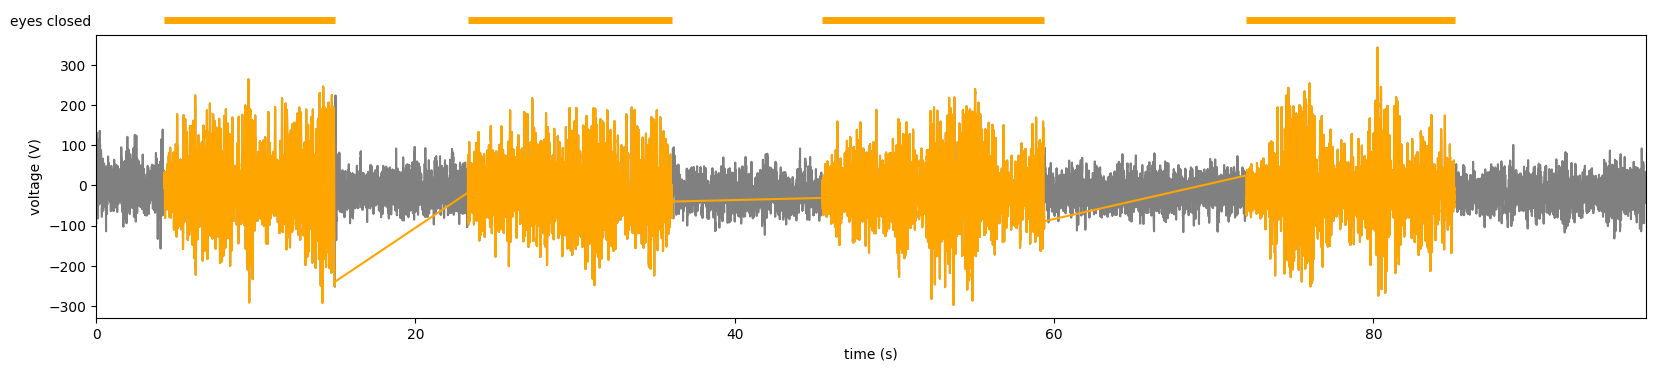

In [7]:
plt.figure(figsize=(20, 4))
npl.plot(eeg, color="gray")
npl.plot(eeg[closed_epochs], color="orange")
npl.overviewstrip(closed_epochs, label="eyes closed", color="orange")

Now we will further explore the characteristics of the EEG by doing some spectral analysis. This decomposes the recording into frequency components.

Though this sounds a little complicated, one way to understand this is through music. The reference tone for an orchestra is an A4, 440 Hz. Suppose we play that note on the piano for 1 second. Now play an A note but one octave higher (880 Hz), also for 1 second. Why do the notes sound different? Though they were played for the same length of time, their **frequency content** was different.

In addition, any note on the piano (or any acoustic instrument for that matter) is composed of **not just one** but a **mixture** of frequencies. Suppose for simplicity that we have an evenly distributed two-component mixture, 50% 250 Hz and 50% 500 Hz. If we change this proportion to 75% 250 Hz and 25% 500 Hz, we will get a different sound. **The mixture of frequencies and the relative proportion/strength of each frequency component is part of the reason why different instruments sound different from each other**, even if they play the **exact same note for the exact same amount of time**.

This is exactl the question we want to explore for the EEG. Namely, (1) what frequencies are present, (2) how strong are they relative to one another, and (3) how long did they last for.

We will investigate by generating a spectrogram, allowing us to visualize the EEG over both time and frequency.

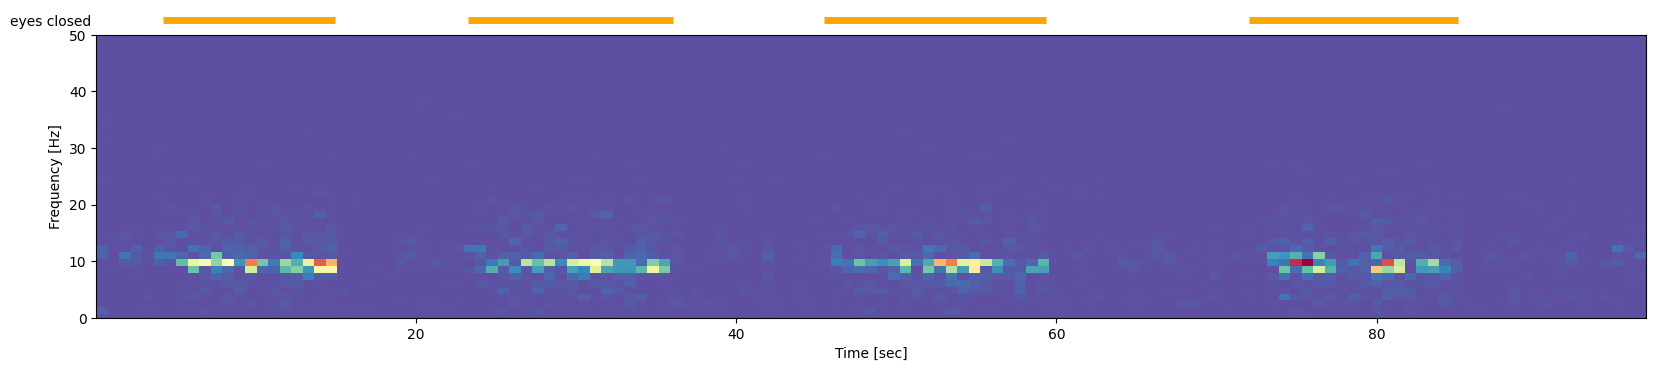

In [8]:
from scipy import signal

f, t, Sxx = signal.spectrogram(x=eeg.data.squeeze(), fs=eeg.fs, nperseg=2**13)
plt.figure(figsize=(20, 4))
plt.pcolormesh(t, f, Sxx, cmap=plt.cm.Spectral_r)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.ylim(0, 50)
npl.overviewstrip(closed_epochs, label="eyes closed", color="orange")

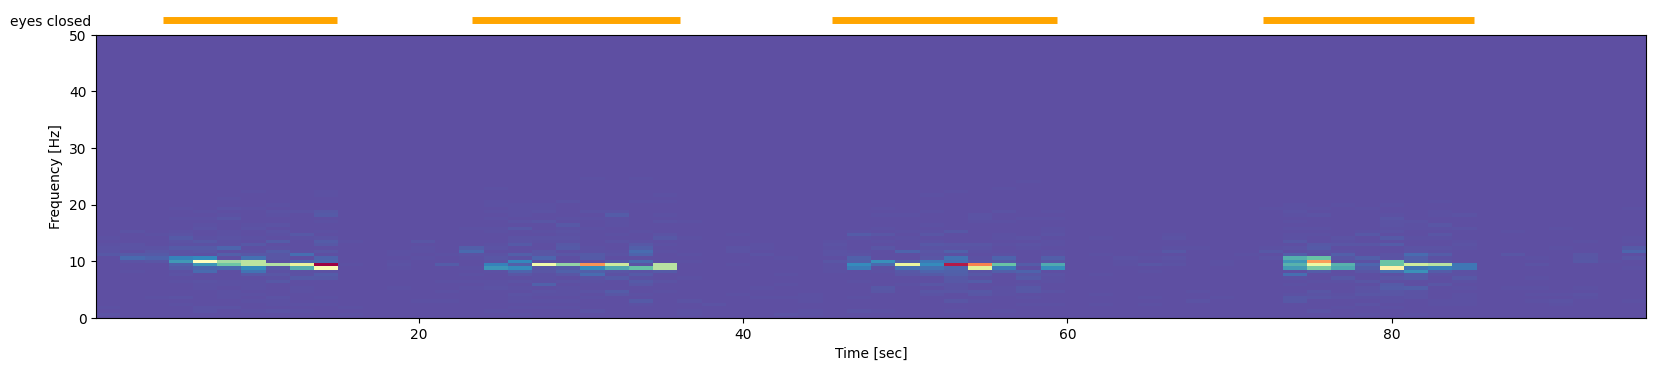

In [9]:
eeg2 = eeg.downsample(fs_out=150)

f, t, Sxx = signal.spectrogram(x=eeg2.data.squeeze(), fs=eeg2.fs)
plt.figure(figsize=(20, 4))
plt.pcolormesh(t, f, Sxx, cmap=plt.cm.Spectral_r)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.ylim(0, 50)
npl.overviewstrip(closed_epochs, label="eyes closed", color="orange")

The two spectrogram plots were generated using the Fourier Transform. It is one of the most important transforms you will encounter, but it also has its drawbacks.

An alternative way to generate spectrograms is through the wavelet transform. One of the features of wavelets is that they can allow for greater temporal resolution. This means we can see the structure of each "eyes closed" event with finer detail. That may sound confusing at first, but hopefully a wavelet-based spectrogram plot will help show this difference.

0.4697887897491455


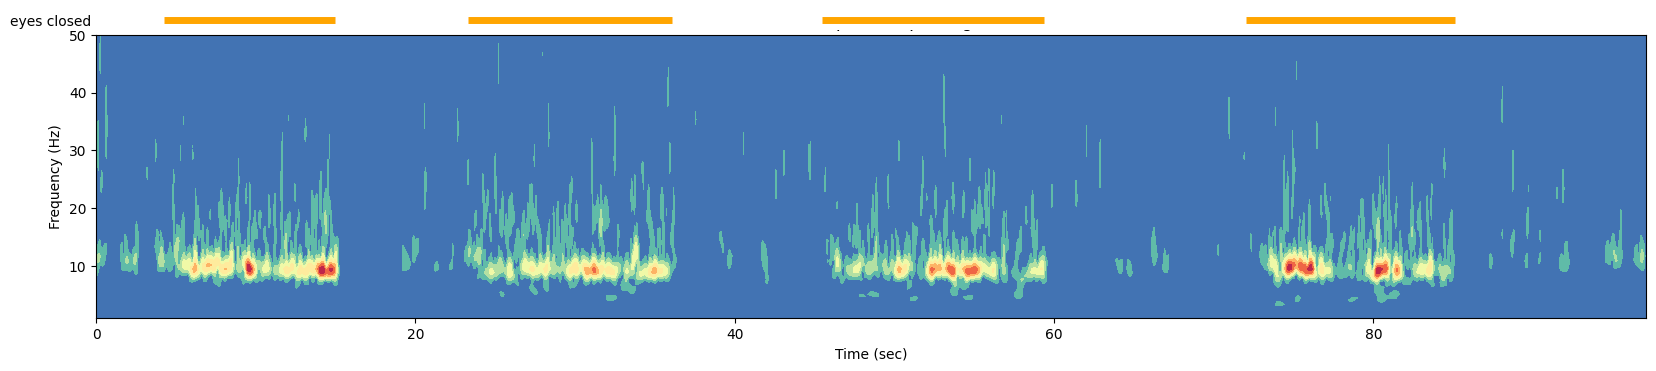

In [10]:
import time

import ghost.wave as gwave

fig, ax = plt.subplots(figsize=(20, 4))
cwt = gwave.ContinuousWaveletTransform()
t0 = time.time()
cwt.transform(eeg2, freq_limits=[1, 50])
cwt.plot(logscale=False, ax=ax, cmap=plt.cm.Spectral_r)
print(time.time() - t0)
npl.overviewstrip(closed_epochs, label="eyes closed", color="orange")

Now that we've tried out two different methods, we see an advantage of using the wavelet transform method. Notice that the regions of high 10 Hz activity align more closely to the "eyes closed" periods that we obtained from the events file.